In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np 
import torchvision

In [2]:
batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(),])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Discriminator(nn.Module):
    def __init__(self, image_nc):
        super(Discriminator, self).__init__()
        model = [
            nn.Conv2d(image_nc, 8, kernel_size=4, stride=2, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=0, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 1, 2),
            nn.Sigmoid()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        output = self.model(x).squeeze()
        return output

In [4]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type='reflect', norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [5]:
class Generator(nn.Module):
    def __init__(self,
                 gen_input_nc,
                 image_nc,
                 ):
        super(Generator, self).__init__()

        encoder_lis = [
            nn.Conv2d(gen_input_nc, 8, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
        ]

        bottle_neck_lis = [ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),
                       ResnetBlock(32),]

        decoder_lis = [
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=0, bias=False),
            nn.InstanceNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, image_nc, kernel_size=6, stride=1, padding=0, bias=False),
            nn.Tanh()
        ]

        self.encoder = nn.Sequential(*encoder_lis)
        self.bottle_neck = nn.Sequential(*bottle_neck_lis)
        self.decoder = nn.Sequential(*decoder_lis)

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottle_neck(x)
        x = self.decoder(x)
        return x

In [6]:
classifier = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet44", pretrained=True)
classifier = classifier.cuda()

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [7]:
def accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy: %s %%' % (100 * correct / total))

In [8]:
accuracy(classifier)

Accuracy: 90.73 %


In [10]:
nf = torch.load("cifar-10_6_blocks_Simple_Gaussian.pt")

In [11]:
pip install git+https://github.com/VLL-HD/FrEIA.git@06a61b77aa2ee80a362abcc334f3801043f428d0

  Cloning https://github.com/VLL-HD/FrEIA.git (to revision 06a61b77aa2ee80a362abcc334f3801043f428d0) to /tmp/pip-req-build-wnxd765q
  Running command git clone -q https://github.com/VLL-HD/FrEIA.git /tmp/pip-req-build-wnxd765q
  Running command git rev-parse -q --verify 'sha^06a61b77aa2ee80a362abcc334f3801043f428d0'
  Running command git fetch -q https://github.com/VLL-HD/FrEIA.git 06a61b77aa2ee80a362abcc334f3801043f428d0
  Running command git checkout -q 06a61b77aa2ee80a362abcc334f3801043f428d0


In [14]:
import torch.optim
import torch.nn as nn
import numpy as np
from FrEIA.framework import *
from FrEIA.modules import *

high_res_blocks = 4     # Number of high-resolution, convolutional blocks
low_res_blocks  = 6     # Number of low-resolution, convolutional blocks
channels_hidden = 128   # Number of hidden channels for the convolutional blocks
batch_norm      = False # Batch normalization?

n_blocks        = 6     # Number of fully-connected blocks
internal_width  = 128   # Internal width of the FC blocks
fc_dropout      = 0.0   # Dropout for FC blocks

clamping        = 1.5   # Clamping parameter for avoiding exploding exponentiation

num_classes     = 10  

nodes = [InputNode(*(3,32,32), name='inp')]

workers         = 1              # Dataloader workers
batch_size      = 64             # Batch-size
n_epochs        = 350            # Number of training epochs

lr              = 1e-4           # Initial learning rate of the optimizer
decay_by        = 0.01           # Learning rate decay
weight_decay    = 1e-5           # Weight decay of the optimizer
betas           = (0.9, 0.999)   # Beta parameters of the Adam optimizer
n_its_per_epoch = 2 ** 10        # Maximum number of training iterations per epoch

do_rev          = False          # Adding the reconstruction error to the objective
do_fwd          = True           # The usual log-likelihood training

init_scale      = 0.03
pre_low_lr      = 1
latent_noise    = 0.1

ndim_x = 3 * 32 * 32

def random_orthog(n):
    w = np.random.randn(n, n)
    w = w + w.T
    w, S, V = np.linalg.svd(w)
    return torch.FloatTensor(w)

# Higher resolution convolutional part
for k in range(high_res_blocks):
    nodes.append(Node(nodes[-1],
                      glow_coupling_layer, {'clamp': clamping, 'F_class': F_conv,
                      'F_args': {'channels_hidden': channels_hidden, 'batch_norm': batch_norm}},
                      name=F'conv_high_res_{k}'))

    nodes.append(Node(nodes[-1], permute_layer, {'seed': k}, name=F'permute_high_res_{k}'))

nodes.append(Node(nodes[-1], i_revnet_downsampling, {}))

# Lower resolution convolutional part
for k in range(low_res_blocks):

    nodes.append(Node(nodes[-1], conv_1x1, {'M': random_orthog(3 * 4)}, name=F'conv_1x1_{k}'))

    nodes.append(Node(nodes[-1], glow_coupling_layer, {'clamp': clamping, 'F_class': F_conv,
                      'F_args': {'channels_hidden': channels_hidden, 'batch_norm': batch_norm}},
                      name=F'conv_low_res_{k}'))

    nodes.append(Node(nodes[-1], permute_layer, {'seed': k}, name=F'permute_low_res_{k}'))

# Make the outputs into a vector, then split off 1/4 of the outputs for the
# fully connected part
nodes.append(Node(nodes[-1], flattening_layer, {}, name='flatten'))

split_node = Node(nodes[-1],
                  Split1D, {'split_size_or_sections': (ndim_x // 4, 3 * ndim_x // 4), 'dim': 0}, name='split')

nodes.append(split_node)

# Fully connected part
for k in range(n_blocks):
    nodes.append(Node(nodes[-1],
                      glow_coupling_layer, {'clamp': clamping,'F_class': F_fully_connected,
                      'F_args':{'dropout': fc_dropout, 'internal_size': internal_width}},
                      name=F'fully_connected_{k}'))

    nodes.append(Node(nodes[-1], permute_layer, {'seed': k}, name=F'permute_{k}'))

# Concatenate the fully connected part and the skip connection to get a single output
nodes.append(Node([nodes[-1].out0, split_node.out1], Concat1d, {'dim': 0}, name='concat'))


nodes.append(OutputNode([nodes[-1].out0], name='out'))


def init_model(mod):
    for key, param in mod.named_parameters():
        split = key.split('.')
        if param.requires_grad:
            param.data = init_scale * torch.randn(param.data.shape).cuda()
            if len(split) > 3 and split[3][-1] == '3': # last convolution in the coeff func
               param.data.fill_(0.)

def save(name):
    save_dict = {'net': model.state_dict()}
    torch.save(save_dict, name)


def load(name):
    state_dicts = torch.load(name)
    model.load_state_dict(state_dicts['net'])


model = ReversibleGraphNet(nodes, verbose=False)
model.cuda()
init_model(model)

load("cifar-10_6_blocks_Simple_Gaussian.pt")



for param in model.parameters():
    param.requires_grad = False

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1 and m.affine:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)



In [ ]:
epochs = 10
lr = 1e-4
generator = Generator(3,3).cuda()
optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
CELoss = nn.CrossEntropyLoss()
for epoch in range(epochs):
  for x,y in train_loader:
    x,y = x.cuda(), y.cuda()
    perturbation = generator(x)
    fool_loss = -CELoss((x+perturbation), y)
    manifold_loss = torch.linalg.norm(model(x)-model(x+perturbation), ord=2, dim=1).mean()
    optimizer.zero_grad()
    loss = fool_loss + manifold_loss
    loss.backward()
    optimizer.step()
    if i%100=0:
      print(f'')

In [ ]:
def adv_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
          outputs = net(model.loss(images, labels, gen_labels)[1] + images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Adversarial accuracy: %s %%' % (100 * correct / total))

In [ ]:
adv_accuracy(classifier)

Adversarial accuracy: 10.52 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

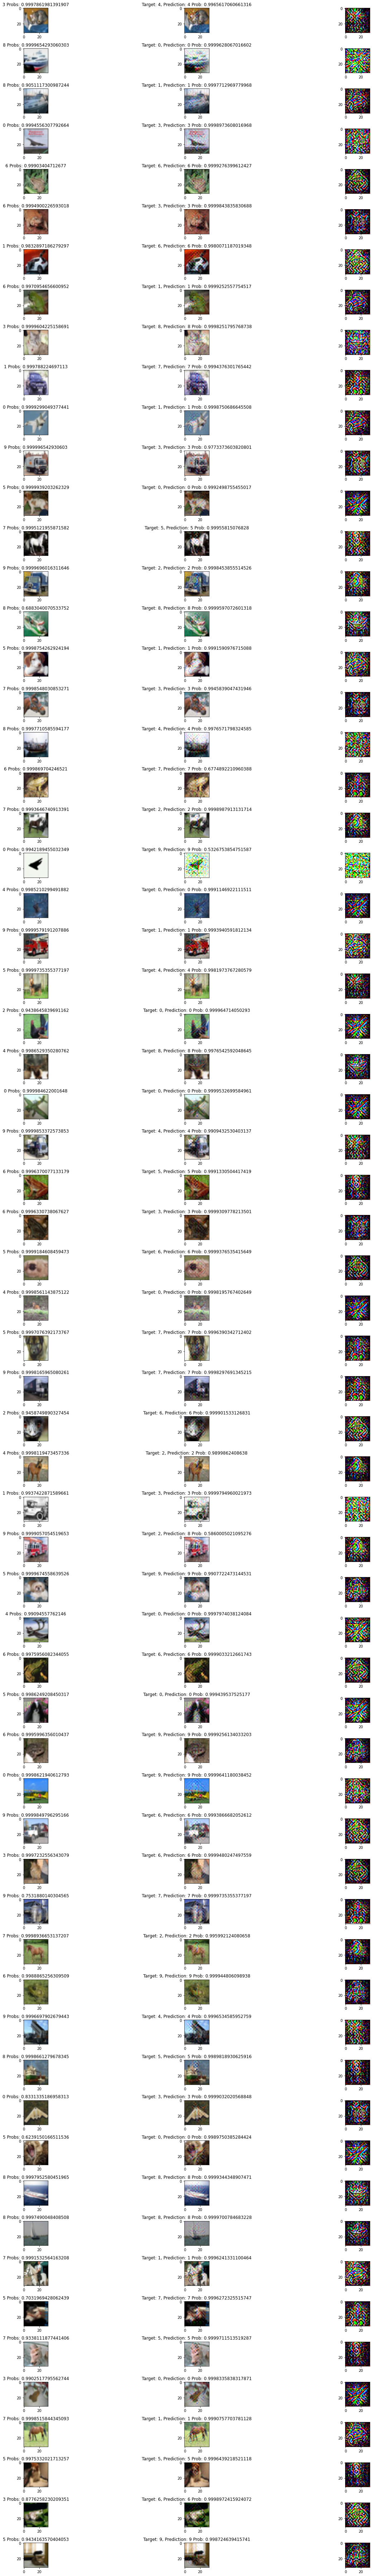

In [ ]:
for x,y in test_loader:
  gen_labels = torch.randint(0,10, (128,)).cuda()
  x,y = x.cuda(), y.cuda()
  base_predictions = F.softmax(classifier(x), 1)
  _, perturbations = model.loss(x,y, gen_labels)
  new_predictions = F.softmax(classifier(x+perturbations), 1)
  fig, axs = plt.subplots(64, 3)
  fig.set_figheight(100)
  fig.set_figwidth(20)
  images = []
  for i in range(64):
          image, perturbation = x[i].detach().cpu().numpy().transpose(1,2,0), perturbations[i].detach().cpu().numpy().transpose(1,2,0)
          images.append(axs[i, 0].imshow(image))
          axs[i,0].title.set_text(f'{torch.argmax(base_predictions[i]).item()} Probs: {torch.max(base_predictions[i]).item()}')
          images.append(axs[i,1].imshow(image+perturbation))
          axs[i,1].title.set_text(f'Target: {gen_labels[i]}, Prediction: {torch.argmax(new_predictions[i]).item()} Prob: {torch.max(new_predictions[i]).item()}')
          images.append(axs[i,2].imshow(perturbation/epsilon, cmap='gray'))
  break

plt.tight_layout()
plt.show()